In [18]:
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import shape
import json
import matplotlib.pyplot as plt
import os

In [ ]:
# Read the geopackage file with the Entropy Weights Method for El Nino and La Nina
path_gpkg = 'outputs/geopackages/ZonalStat_Ecoregions_EWM_v2.gpkg'
if not os.path.exists(path_gpkg):
    raise FileNotFoundError(f"File not found: {path_gpkg}")

# Read the geopackage using geopandas
ecoregions_exp = gpd.read_file(path_gpkg, layer="zonal_statistics")
ecoregions_exp = ecoregions_exp.drop(['fire_count', 'fire_area_ha'], axis=1)
ecoregions_exp = ecoregions_exp.rename(columns={
    'ZonalStat_Ecoregions_EWM_nino_EWMnino_median': 'EWMnino',
    'ZonalStat_Ecoregions_EWM_nino_EWMnina_median': 'EWMnina'
    })
ecoregions_exp.dtypes

OBJECTID       float64
ECO_NAME        object
BIOME_NUM      float64
BIOME_NAME      object
REALM           object
ECO_BIOME_      object
NNH              int64
ECO_ID           int64
SHAPE_LENG     float64
SHAPE_AREA     float64
NNH_NAME        object
COLOR           object
COLOR_BIO       object
COLOR_NNH       object
LICENSE         object
EWMnina        float64
EWMnino        float64
geometry      geometry
dtype: object

In [23]:
# Read CSV with fires
df_fires_50 = pd.read_csv('inputs/04_csv/PrimaryLoss_by_Fires_Stats_50_v3.csv')
df_fires_50 = df_fires_50.drop(['.geo', 'system:index', 'PrimaryLoss_by_fires50', 'Primary_loss50'], axis=1)
df_fires_50 = df_fires_50.rename(columns={'Loss_Fires_50%': 'PrimaryLoss_Fires50%'})
df_fires_50.dtypes

BIOME_NAME               object
BIOME_NUM               float64
COLOR                    object
COLOR_BIO                object
COLOR_NNH                object
ECO_BIOME_               object
ECO_ID                    int64
ECO_NAME                 object
LICENSE                  object
PrimaryLoss_Fires50%    float64
NNH                       int64
NNH_NAME                 object
OBJECTID                float64
REALM                    object
SHAPE_AREA              float64
SHAPE_LENG              float64
dtype: object

In [ ]:
# Read the full CSV as a dataframe
gfc_df = pd.read_csv('inputs/04_csv/ZonalStatistics_Ecoregions_Complete.csv')
gfc_df.dtypes

system:index                  object
BIOME_NAME                    object
BIOME_NUM                    float64
COLOR                         object
COLOR_BIO                     object
COLOR_NNH                     object
ECO_BIOME_                    object
ECO_ID                         int64
ECO_NAME                      object
Forest50                     float64
ForestLoss_Fires50           float64
Forest_Loss50                float64
LICENSE                       object
NNH                            int64
NNH_NAME                      object
OBJECTID                     float64
PrimaryForest50              float64
PrimaryForestLoss_Fires50    float64
PrimaryForest_Loss50         float64
REALM                         object
SHAPE_AREA                   float64
SHAPE_LENG                   float64
.geo                          object
dtype: object

In [5]:
#  Rename geometry column
gfc_df = gfc_df.rename(columns={'.geo': 'geometry'})
gfc_df.columns

Index(['system:index', 'BIOME_NAME', 'BIOME_NUM', 'COLOR', 'COLOR_BIO',
       'COLOR_NNH', 'ECO_BIOME_', 'ECO_ID', 'ECO_NAME', 'Forest50',
       'ForestLoss_Fires50', 'Forest_Loss50', 'LICENSE', 'NNH', 'NNH_NAME',
       'OBJECTID', 'PrimaryForest50', 'PrimaryForestLoss_Fires50',
       'PrimaryForest_Loss50', 'REALM', 'SHAPE_AREA', 'SHAPE_LENG',
       'geometry'],
      dtype='object')

In [27]:
# Identify the common column
common_column = 'ECO_NAME'

# Merge the DataFrames based on the common column
# Select only the two additional columns from CSV
additional_columns = [col for col in df_fires_50.columns if col not in gfc_df.columns and col != common_column]
# Merge the DataFrame with the GeoDataFrame
gfc_df = gfc_df.merge(df_fires_50[[common_column] + additional_columns], on=common_column, how="left")
gfc_df = gfc_df.drop('primaryLoss_fires%', axis=1)
gfc_df.dtypes

system:index                  object
BIOME_NAME                    object
BIOME_NUM                    float64
COLOR                         object
COLOR_BIO                     object
COLOR_NNH                     object
ECO_BIOME_                    object
ECO_ID                         int64
ECO_NAME                      object
Forest50                     float64
ForestLoss_Fires50           float64
Forest_Loss50                float64
LICENSE                       object
NNH                            int64
NNH_NAME                      object
OBJECTID                     float64
PrimaryForest50              float64
PrimaryForestLoss_Fires50    float64
PrimaryForest_Loss50         float64
REALM                         object
SHAPE_AREA                   float64
SHAPE_LENG                   float64
geometry                      object
primaryLoss_rate             float64
PrimaryLoss_Fires50%         float64
dtype: object

In [37]:
# Identify the common column
common_column = 'ECO_NAME'

# Merge the DataFrames based on the common column
# Select only the two additional columns from CSV
additional_columns = [col for col in ecoregions_exp.columns if col not in gfc_df.columns and col != common_column]
# Merge the DataFrame with the GeoDataFrame
gfc_df = gfc_df.merge(ecoregions_exp[[common_column] + additional_columns], on=common_column, how="left")
# gfc_df = gfc_df.drop('primaryLoss_fires%', axis=1)
gfc_df.dtypes

system:index                  object
BIOME_NAME                    object
BIOME_NUM                    float64
COLOR                         object
COLOR_BIO                     object
COLOR_NNH                     object
ECO_BIOME_                    object
ECO_ID                         int64
ECO_NAME                      object
Forest50                     float64
ForestLoss_Fires50           float64
Forest_Loss50                float64
LICENSE                       object
NNH                            int64
NNH_NAME                      object
OBJECTID                     float64
PrimaryForest50              float64
PrimaryForestLoss_Fires50    float64
PrimaryForest_Loss50         float64
REALM                         object
SHAPE_AREA                   float64
SHAPE_LENG                   float64
geometry                      object
primaryLoss_rate             float64
PrimaryLoss_Fires50%         float64
EWMnina                      float64
EWMnino                      float64
d

In [28]:
# Calculate the deforestation rate (% per year) for each ecoregion
gfc_df['primaryLoss_rate'] = (gfc_df['PrimaryForest_Loss50'] / (gfc_df['PrimaryForest50'] * 23)) * 100
gfc_df['primaryLoss_rate'].head()

0    0.100300
1         NaN
2    1.557807
3    0.228556
4    0.365950
Name: primaryLoss_rate, dtype: float64

In [29]:
# 2. Convert JSON geometry to Shapely objects
gfc_df['geometry'] = gfc_df['geometry'].apply(lambda x: shape(json.loads(x)))
gfc_df.dtypes

TypeError: the JSON object must be str, bytes or bytearray, not MultiPolygon

In [38]:
# 3. Create GeoDataFrame from dataframe
gdf_ecoregions = gpd.GeoDataFrame(gfc_df, geometry='geometry')
gdf_ecoregions.shape

(179, 27)

In [39]:
gdf_ecoregions.dtypes

system:index                   object
BIOME_NAME                     object
BIOME_NUM                     float64
COLOR                          object
COLOR_BIO                      object
COLOR_NNH                      object
ECO_BIOME_                     object
ECO_ID                          int64
ECO_NAME                       object
Forest50                      float64
ForestLoss_Fires50            float64
Forest_Loss50                 float64
LICENSE                        object
NNH                             int64
NNH_NAME                       object
OBJECTID                      float64
PrimaryForest50               float64
PrimaryForestLoss_Fires50     float64
PrimaryForest_Loss50          float64
REALM                          object
SHAPE_AREA                    float64
SHAPE_LENG                    float64
geometry                     geometry
primaryLoss_rate              float64
PrimaryLoss_Fires50%          float64
EWMnina                       float64
EWMnino     

<Axes: >

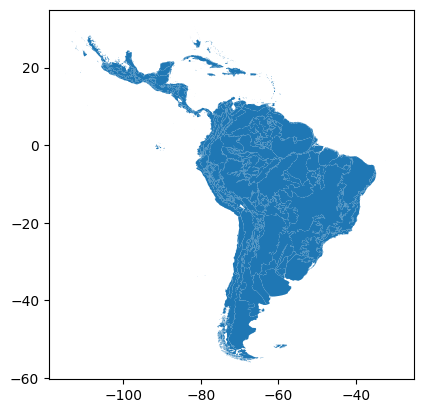

In [32]:
gdf_ecoregions.plot()

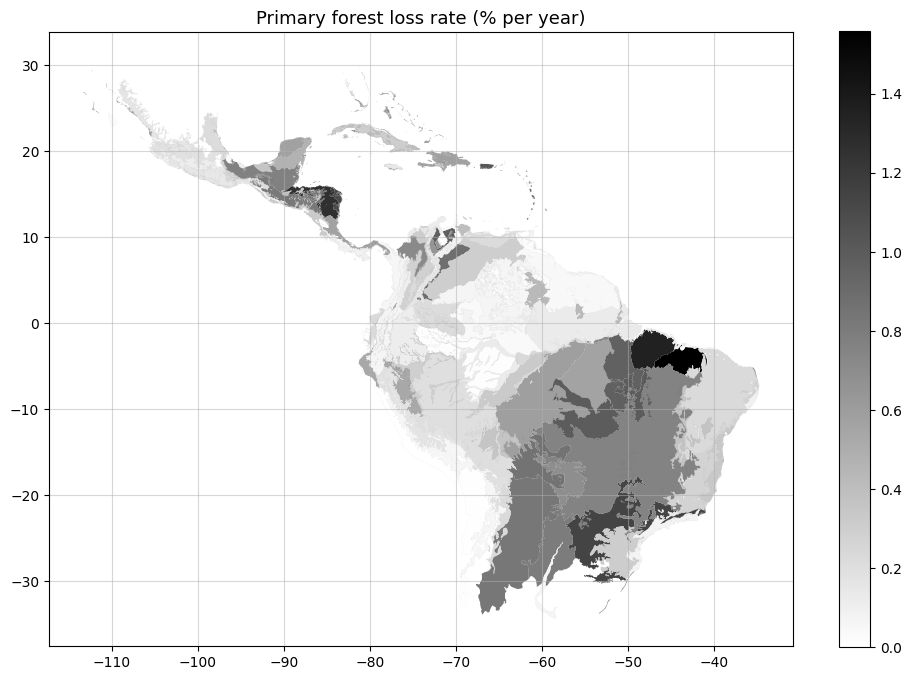

In [33]:

# Visualize the deforestation rate for each ecoregion

# plot using a grayscale colormap
fig, ax = plt.subplots(figsize=(12, 8))

gdf_ecoregions.plot(
    column='primaryLoss_rate',
    cmap='gray_r',
    edgecolor='black',
    linewidth=0.01,
    ax=ax,
    legend=True 
)
ax.grid(alpha=0.5)

ax.set_title('Primary forest loss rate (% per year)', fontsize=13)
plt.show()

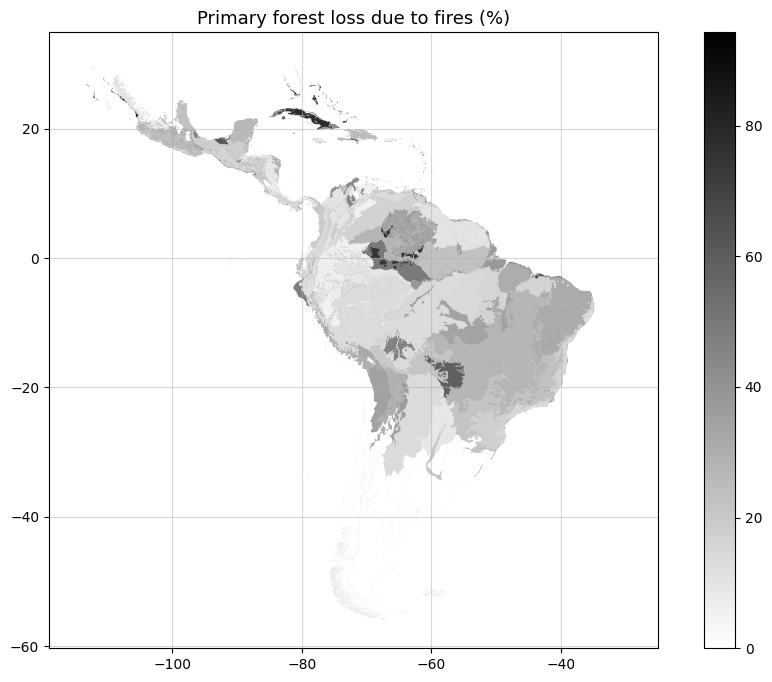

In [35]:
# Visualize the deforestation rate for each ecoregion

# plot using a grayscale colormap
fig, ax = plt.subplots(figsize=(12, 8))

gdf_ecoregions.plot(
    column='PrimaryLoss_Fires50%',
    cmap='gray_r',
    edgecolor='black',
    linewidth=0.01,
    ax=ax,
    legend=True 
)
ax.grid(alpha=0.5)

ax.set_title('Primary forest loss due to fires (%)', fontsize=13)
plt.show()

In [42]:
gdf_ecoregions.dtypes

system:index                   object
BIOME_NAME                     object
BIOME_NUM                     float64
COLOR                          object
COLOR_BIO                      object
COLOR_NNH                      object
ECO_BIOME_                     object
ECO_ID                          int64
ECO_NAME                       object
Forest50                      float64
ForestLoss_Fires50            float64
Forest_Loss50                 float64
LICENSE                        object
NNH                             int64
NNH_NAME                       object
OBJECTID                      float64
PrimaryForest50               float64
PrimaryForestLoss_Fires50     float64
PrimaryForest_Loss50          float64
REALM                          object
SHAPE_AREA                    float64
SHAPE_LENG                    float64
geometry                     geometry
primaryLoss_rate              float64
PrimaryLoss_Fires50%          float64
EWMnina                       float64
EWMnino     

In [44]:
# Save the updated GeoDataFrame to a new geopackage
gdf_ecoregions = gdf_ecoregions.set_crs(epsg=4326, inplace=True)
gdf_ecoregions.to_file('outputs/geopackages/ZonalStat_Ecoregions_EWM_v2.gpkg', driver='GPKG', layer='zonal_statistics_v2')